# Checking Common Support

The common support assumption states that each unit has a non-zero probability of receiving each treatment level - $\forall x \in X, P(T=1|X=x) > 0$ and $P(T=0|X=x) > 0$.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Load the data
data = pd.read_csv('data/processed_data.csv')

# Prepare the feature matrix
X = data.drop(columns=['Adult', 'Target'])
X.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Admission grade,Displaced,Educational special needs,Gender,Scholarship holder,Unemployment rate,Inflation rate,GDP
0,1,17,5,171,1,Complete Secondary Education,122.0,Incomplete Secondary Education,Complete Secondary Education,Administrative,Plant and Machine Operators,127.3,1,0,1,0,10.8,1.4,1.74
1,1,15,1,9254,1,Complete Secondary Education,160.0,Complete Secondary Education,Higher Education - Undergraduate,Professionals,Professionals,142.5,1,0,1,0,13.9,-0.3,0.79
2,1,1,5,9070,1,Complete Secondary Education,122.0,Other Specific Qualifications,Other Specific Qualifications,Plant and Machine Operators,Plant and Machine Operators,124.8,1,0,1,0,10.8,1.4,1.74
3,1,17,2,9773,1,Complete Secondary Education,122.0,Other Specific Qualifications,Other Specific Qualifications,Administrative,Professionals,119.6,1,0,0,0,9.4,-0.8,-3.12
4,2,39,1,8014,0,Complete Secondary Education,100.0,Other Specific Qualifications,Other Specific Qualifications,Plant and Machine Operators,Plant and Machine Operators,141.5,0,0,0,0,13.9,-0.3,0.79


In [3]:
# separate numerical and categorical columns
numerical_columns = ['Previous qualification (grade)', 'Admission grade', 'Unemployment rate', 'Inflation rate', 'GDP']
categorical_columns = list(set(X.columns) - set(numerical_columns))

# Standardize the numerical columns
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# One-hot encode the categorical columns and remove the original columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

In [8]:
# Estimate propensity scores
propensity_model = LogisticRegression(random_state=42)
propensity_model.fit(X, data['Adult'])
propensity_scores = propensity_model.predict_proba(X)[:, 1]

# Add propensity scores to the dataframe
data['propensity_score'] = propensity_scores

[0.21380405 0.12952125 0.25933854 ... 0.10312549 0.04206471 0.08348846]


In [5]:
# Check common support
min_treated = data[data['Adult'] == 1]['propensity_score'].min()
max_treated = data[data['Adult'] == 1]['propensity_score'].max()
min_untreated = data[data['Adult'] == 0]['propensity_score'].min()
max_untreated = data[data['Adult'] == 0]['propensity_score'].max()

print(f"Treated group propensity score range: [{min_treated:.4f}, {max_treated:.4f}]")
print(f"Untreated group propensity score range: [{min_untreated:.4f}, {max_untreated:.4f}]")

if min_treated <= max_untreated and min_untreated <= max_treated:
    print("The common support condition appears to hold.")
else:
    print("The common support condition may not hold.")

# Calculate the overlap coefficient
overlap_min = max(min_treated, min_untreated)
overlap_max = min(max_treated, max_untreated)
overlap_coefficient = (overlap_max - overlap_min) / (max_treated - min_untreated)

print(f"Overlap coefficient: {overlap_coefficient:.4f}")

Treated group propensity score range: [0.0220, 1.0000]
Untreated group propensity score range: [0.0071, 0.9862]
The common support condition appears to hold.
Overlap coefficient: 0.9712


In [6]:
PLOTS_DIR = '/Users/gurkeinan/semester6/Causal-Inference/Project/plots'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gurkeinan/semester6/Causal-Inference/Project/plots/propensity_score_distributions.png'

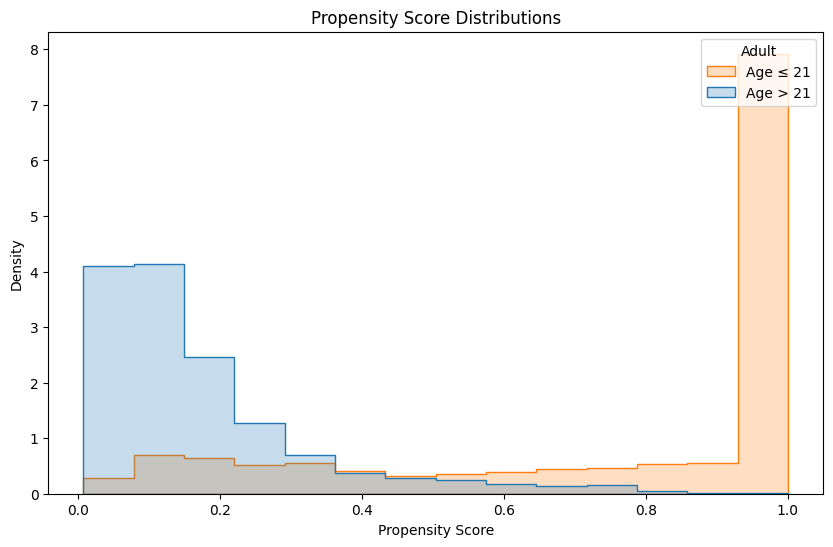

In [7]:
# Visualize propensity score distributions
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='propensity_score', hue='Adult', 
             element='step', stat='density', common_norm=False)
plt.title('Propensity Score Distributions')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(title='Adult', labels=['Age ≤ 21', 'Age > 21'])

# Save the plot
plt.savefig(f'{PLOTS_DIR}/propensity_score_distributions.png')

plt.show()

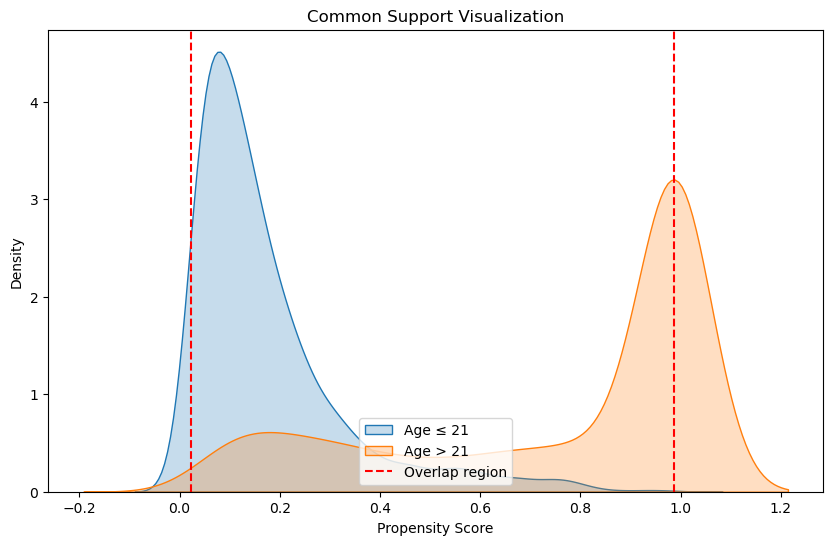

In [35]:
# Visualize common support
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data[data['Adult'] == 0]['propensity_score'], 
            label='Age ≤ 21', shade=True)
sns.kdeplot(data=data[data['Adult'] == 1]['propensity_score'], 
            label='Age > 21', shade=True)
plt.axvline(overlap_min, color='r', linestyle='--', label='Overlap region')
plt.axvline(overlap_max, color='r', linestyle='--')
plt.title('Common Support Visualization')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()

# Save the plot
plt.savefig(f'{PLOTS_DIR}/common_support.png')

plt.show()